<a href="https://colab.research.google.com/github/fabiomattes2016/previsor-btc-python/blob/main/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Conferindo libs instaladas
!pip install numpy
!pip install pandas
!pip install pandas-datareader
!pip install matplotlib
!pip install tensorflow
!pip install sklearn
!pip install scikit-learn
!pip install yfinance

     |████████████████████████████████| 6.3 MB 11.3 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=779e9357fbf311bc25b98ca498057f737e61dc870c61ff512ff995816ee3c38b
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
# Importando libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import tensorflow as tf
import os
import json
import requests
import locale

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from pandas_datareader import data as pdr

In [3]:
# Configurando as moedas
crypto_currency = 'BTC'
against_currency = 'USD'

In [4]:
# Definindo o intervalo de datas
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

In [5]:
# Pegando as informações
yf.pdr_override()
data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', start, end)
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


In [6]:
# Preparando os dados
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data) - future_day):
  x_train.append(scaled_data[x-prediction_days:x, 0])
  y_train.append(scaled_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [7]:
# Criando a rede neural
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
61/61 [==============================] - 10s 11ms/step - loss: 0.0138
Epoch 2/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0064
Epoch 3/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0062
Epoch 4/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0058
Epoch 5/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0055
Epoch 6/25
61/61 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 7/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 8/25
61/61 [==============================] - 1s 10ms/step - loss: 0.0046
Epoch 9/25
61/61 [==============================] - 1s 10ms/step - loss: 0.0036
Epoch 10/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0042
Epoch 11/25
61/61 [==============================] - 1s 10ms/step - loss: 0.0037
Epoch 12/25
61/61 [==============================] - 1s 9ms/step - loss: 0.0033
Epoch 13/25
61/61 [========================

[*********************100%***********************]  1 of 1 completed


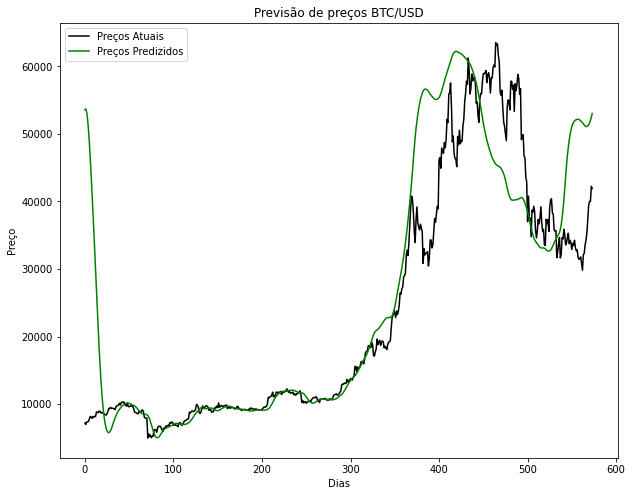

In [8]:
# Testando o modelo
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = pdr.get_data_yahoo(f'{crypto_currency}-{against_currency}', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append((model_inputs[x - prediction_days:x, 0]))

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.figure(figsize=(10, 8))
plt.plot(actual_prices, color='black', label='Preços Atuais')
plt.plot(prediction_prices, color='green', label='Preços Predizidos')
plt.title(f'Previsão de preços {crypto_currency}/{against_currency}')
plt.xlabel('Dias')
plt.ylabel('Preço')
plt.legend(loc='upper left')
plt.show()


In [9]:
# Predizendo o dia seguinte
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(prediction[0][0])

53711.99


In [10]:
# Convertendo em Reais
def real_br_money_mask(my_value):
    a = '{:,.2f}'.format(float(my_value))
    b = a.replace(',','v')
    c = b.replace('.',',')
    return c.replace('v','.')

url = 'https://economia.awesomeapi.com.br/json/last/usd'
requisicao = requests.get(url)
cotacao = json.loads(requisicao.text)
preco=cotacao['USDBRL']['high']

convertido = float(prediction[0][0]) * float(preco)

locale.setlocale(locale.LC_MONETARY, 'en_US.UTF-8')
print('Cotação do dolar é ', locale.currency(float(preco)))

print(f'Previsão preço para {crypto_currency} é de R$', real_br_money_mask(float(convertido)))

Cotação do dolar é  $5.23
Previsão preço para BTC é de R$ 280.806,27
